# 5.2. Método de revisão *Impresso*

Esse notebook[^impresso-rev] foi desenvolvido por  Ehrmann, Maud, Estelle Bunout, e Marten Düring e apresenta um método de avaliação de interfaces gráficas de jornais históricos. Os resultados da pesquisa foram publicados 2017 no artigo [Historical Newspaper User Interfaces: A Review](http://library.ifla.org/id/eprint/2578/).

Busco aqui aplicar o mesmo método a partir dos dados das três hemerotecas estudadas: Hemeroteca Digital da Biblioteca Nacional, Hemeroteca Digital da Biblioteca Nacional de Portugal, Hemeroteca Municipal de Lisboa.

Os gráficos gerados estão armazenados em [`charts/`](https://github.com/ericbrasiln/hemdig-framework/tree/31-jupyter-book/book/part2/capitulo5/charts).

[^impresso-rev]: Maud Ehrmann, Estelle Bunout, and Marten Düring. “Survey of Digitized Newspaper Interfaces (dataset and Notebooks)”. Zenodo, August 16, 2019. https://doi.org/10.5281/zenodo.3369875.

```{admonition} Nota
:class: note
Esse notebook compõe o repositório[Survey of Digitized Newspaper Interfaces (dataset and Notebooks)](https://doi.org/10.5281/zenodo.3369875) e está licenciado sob a licença [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.pt_BR). 

Busquei manter o código e documentação mais próximo do original. Quando foi necessário realizar mudanças, elas foram documentadas.
```

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from radar_factory import build_single_radar, build_multiple_radar, build_single_radar_free

## Preparing data
### Loading the review spreasheet as a multi-index (tsv)

In [2]:
base = pd.read_csv("../../../data/avaliacao_interfaces/InterfaceReview-pt-2023.csv", sep="\t", index_col= [0,1], skipinitialspace=True)

In [3]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family Property                                                                          
interface       URL                                                   http://memoria.bn.br/hdb/   
                Target area                                                                  BR   
                Creator                                            Fundação Biblioteca Nacional   
                Purpose and scope             Coleção de periódicos digitalizados do acervo ...   
                Approximate date of creation                                               2012   

                                               Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family Property                                                                          
interface       URL                                        https://bndigital.bnportugal.gov.pt/   
                Target area                                                                  PT   
                Creator                                         Biblioteca Nacional de Portugal   
                Purpose and scope             Acervo digitalizado da Biblioteca Nacional de ...   
                Approximate date of creation                                                  u   

                                                             Hemeroteca Digital de Lisboa (HDL)  
Property family Property                                                                         
interface       URL                                     https://hemerotecadigital.cm-lisboa.pt/  
                Target area                                                                  PT  
                Creator                                                   Bibliotecas de Lisboa  
                Purpose and scope             Periódicos, legislação obras raras digitalizad...  
                Approximate date of creation                                                  u

#### Testing some indexing

In [4]:
# about multilingual collections
base.loc['newspaper collection', 'Languages of the collections'].value_counts()

pt    3
Name: (newspaper collection, Languages of the collections), dtype: int64

In [5]:
# about multilingual collections
base.loc['interface', 'Access model'].value_counts()

free    3
Name: (interface, Access model), dtype: int64

In [6]:
# about multilingual collections
base.loc['interface', 'Interface provider'].value_counts()

Instituição Pública    2
Private (DocPro)       1
Name: (interface, Interface provider), dtype: int64

### Some cleaning and preparation

In [7]:
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if type(x) is str else x
    return df.applymap(trim_strings)

In [8]:
# trim
base = trim_all_columns(base)

# removing non binary features
base = base.drop('interface', level=0)
base = base.drop('newspaper collection', level=0)
base = base.drop('Languages of the collections', level=1) # from 'newspaper collection'

base = base.drop('Other', level=1)
base = base.drop('Download options (file formats)', level=1)

#Replace n and y by 0 and 1 
base = base.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'], 
                    value=[1,1,1,1,0,0,0,0,0,0])

In [9]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family    Property                                                    
newspaper metadata Alternative titles                                      0   
                   Place of publication                                    1   
                   Geographic coverage                                     1   
                   Publisher                                               0   
                   Date range                                              1   

                                         Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family    Property                                                                 
newspaper metadata Alternative titles                                                   1   
                   Place of publication                                                 1   
                   Geographic coverage                                                  0   
                   Publisher                                                            1   
                   Date range                                                           1   

                                         Hemeroteca Digital de Lisboa (HDL)  
Property family    Property                                                  
newspaper metadata Alternative titles                                     1  
                   Place of publication                                   1  
                   Geographic coverage                                    0  
                   Publisher                                              1  
                   Date range                                             1

## Interface charts
### Generic counts

In [10]:
base.loc[:,'Total'] = base.sum(axis=1, numeric_only=True)
base['Total (%)'] = base['Total']/base['Total'].sum() * 100

In [11]:
base.head()

Hemeroteca Digital Brasileira (HDB)  \
Property family    Property                                                    
newspaper metadata Alternative titles                                      0   
                   Place of publication                                    1   
                   Geographic coverage                                     1   
                   Publisher                                               0   
                   Date range                                              1   

                                         Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family    Property                                                                 
newspaper metadata Alternative titles                                                   1   
                   Place of publication                                                 1   
                   Geographic coverage                                                  0   
                   Publisher                                                            1   
                   Date range                                                           1   

                                         Hemeroteca Digital de Lisboa (HDL)  \
Property family    Property                                                   
newspaper metadata Alternative titles                                     1   
                   Place of publication                                   1   
                   Geographic coverage                                    0   
                   Publisher                                              1   
                   Date range                                             1   

                                         Total  Total (%)  
Property family    Property                                
newspaper metadata Alternative titles        2   2.127660  
                   Place of publication      3   3.191489  
                   Geographic coverage       1   1.063830  
                   Publisher                 2   2.127660  
                   Date range                3   3.191489

In [12]:
base.shape

(125, 5)

In [13]:
zeros = base.loc[base['Total'].values  == 0]
all = base.loc[base['Total'].values  == 24]
upper = base.loc[base['Total'].values  >= 12]
three_quarter = base.loc[base['Total'].values  >= 18]
lower = base.loc[ (base['Total'].values  <12) & (base['Total'].values  != 0)]
lower_full = base.loc[base['Total'].values  <12]

In [14]:
zeros

Hemeroteca Digital Brasileira (HDB)  \
Property family    Property                                                                    
newspaper metadata ISSN, OCLC, LCCN                                                        0   
browsing           By user tag                                                             0   
search             Fuzzy search                                                            0   
                   Proximity search                                                        0   
                   Limit by NP segments                                                    0   
...                                                                                      ...   
connectivity       SW technologies                                                         0   
apis               Link to source code of the interface                                    0   
                   API                                                                     0   
                   IIIF Image API                                                          0   
                   IIIF Presentation API                                                   0   

                                                         Biblioteca Nacional Digital de Portugal (BND-PT)  \
Property family    Property                                                                                 
newspaper metadata ISSN, OCLC, LCCN                                                                     0   
browsing           By user tag                                                                          0   
search             Fuzzy search                                                                         0   
                   Proximity search                                                                     0   
                   Limit by NP segments                                                                 0   
...                                                                                                   ...   
connectivity       SW technologies                                                                      0   
apis               Link to source code of the interface                                                 0   
                   API                                                                                  0   
                   IIIF Image API                                                                       0   
                   IIIF Presentation API                                                                0   

                                                         Hemeroteca Digital de Lisboa (HDL)  \
Property family    Property                                                                   
newspaper metadata ISSN, OCLC, LCCN                                                       0   
browsing           By user tag                                                            0   
search             Fuzzy search                                                           0   
                   Proximity search                                                       0   
                   Limit by NP segments                                                   0   
...                                                                                     ...   
connectivity       SW technologies                                                        0   
apis               Link to source code of the interface                                   0   
                   API                                                                    0   
                   IIIF Image API                                                         0   
                   IIIF Presentation API                                                  0   

                                                         Total  Total (%)  
Property family    Property                                                
ne

In [15]:
all

,,Hemeroteca Digital Brasileira (HDB),Biblioteca Nacional Digital de Portugal (BND-PT),Hemeroteca Digital de Lisboa (HDL),Total,Total (%)
Property family,Property,,,,,


In [16]:
lower.shape

(52, 5)

In [17]:
upper.shape

(0, 5)

In [18]:
lower_full.shape

(125, 5)

In [19]:
three_quarter.shape

(0, 5)

#### Group by for aggregated counts

In [20]:
# Sum values of level 1 => 'grade' of each interface per family of features
level_0 = base.groupby(level=0).sum()

#level_0 = base.groupby(level=0).sum(numeric_only=True)

# re-order index
level_0 = level_0.reindex(["newspaper metadata", 
                 "apis",
                 "connectivity",
                 "info on digitization",
                 "enrichment",
                 "user interaction",
                 "viewer",
                 "result display",
                 "result filtering",
                 "result sorting",
                 "search",
                 "browsing"
                    ])

In [21]:
# copy level_0 to analyze
level_0_copy = level_0.copy()

In [22]:
level_0_copy

,Hemeroteca Digital Brasileira (HDB),Biblioteca Nacional Digital de Portugal (BND-PT),Hemeroteca Digital de Lisboa (HDL),Total,Total (%)
Property family,,,,,
newspaper metadata,4,9,8,21,22.340426
apis,0,0,0,0,0.000000
connectivity,0,1,0,1,1.063830
info on digitization,1,1,0,2,2.127660
enrichment,0,0,0,0,0.000000
user interaction,1,1,0,2,2.127660
viewer,6,8,4,18,19.148936
result display,3,3,1,7,7.446809
result filtering,3,6,0,9,9.574468


#### Observations per feature family

In [23]:
# Não é necessário pelo pequeno número de interfaces analisadas. Vamos trabalhar com o valor absoluto
#Total sum per row, ie. per feature family (=> how good are all interfaces for a certain aspect): 
#level_0.loc[:,'Total'] = level_0.sum(axis=1)
#level_0['Total (%)'] = level_0['Total']/level_0['Total'].sum() * 100

In [24]:
# getting the labels
labels = level_0_copy.index

#### Test radar with one interface

In [25]:
# Get all rows, just for the first columns, transpose it (for the radar factory) and take only the values
first_interface = level_0_copy.iloc[:12, :1].T.values

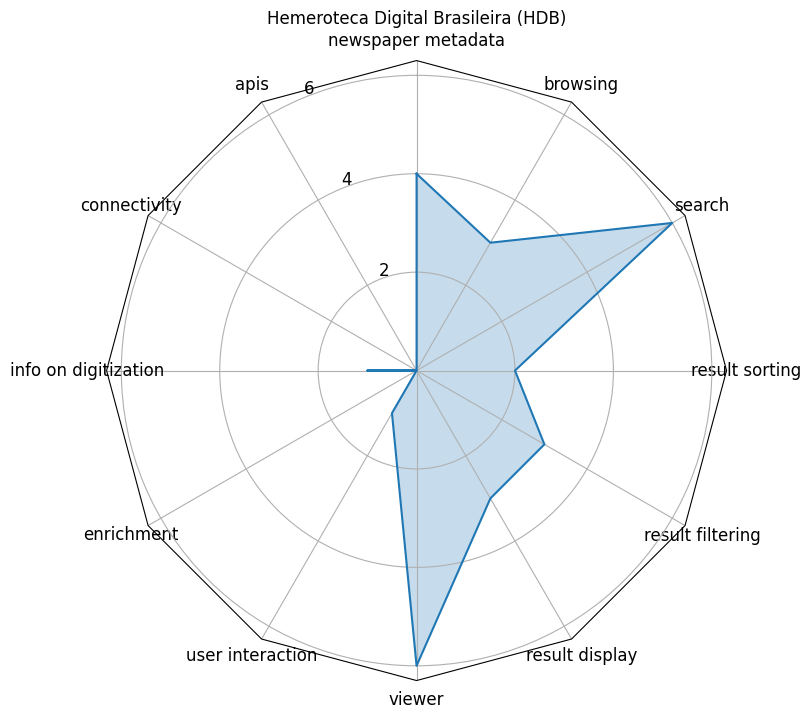

In [26]:
build_single_radar(labels, values=first_interface, title=level_0_copy.columns[0], grid=[2,4,6,8], figure_title='HDB', output_type='png')

#### Radar view for each interface in one figure

:warning: Vamos trabalhar com valores inteiros pelo pequeno número de interfaces analisadas. Assim as próximas células não serão executadas. Utilizaremos o df `level_0_copy` para as próximas análises.

In [27]:
# same with percentages
#level_0_percent = base.groupby(level=0).sum().apply(lambda x: 100*x/float(x.sum()))

# re-order index
#level_0_percent = level_0_percent.reindex(["newspaper metadata", 
#                 "apis",
#                 "connectivity",
#                 "info on digitization",
#                 "enrichment",
#                 "user interaction",
#                 "viewer",
#                 "result display",
#                 "result filtering",
#                 "result sorting",
#                 "search",
#                 "browsing"
#                    ])

In [28]:
#level_0_percent.iloc[:12, 4].index

In [29]:
# checking we have 100 everywhere
#level_0_percent.sum()

In [30]:
#level_0_percent.max().max()

In [31]:
#level_0_percent.iloc[:12, :24]

In [32]:
all_interfaces_percents = level_0_copy.iloc[:12, :].T.values

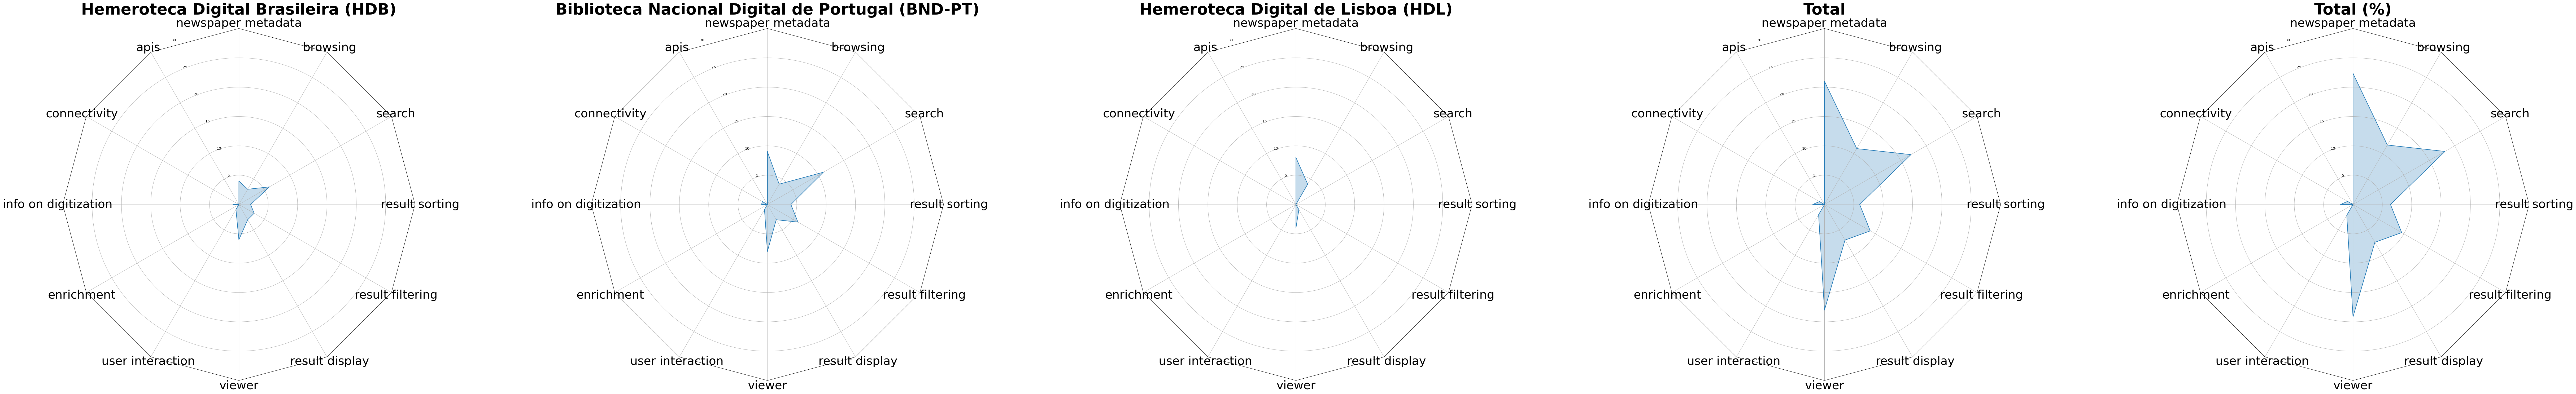

In [33]:
build_multiple_radar(labels, all_interfaces_percents, level_0_copy.columns[:], 'all-interfaces-single', output_type='png')

#### Global radar view (i.e. for all interfaces) over all features

In [34]:
level_0_copy.iloc[:,4]

Property family
newspaper metadata      22.340426
apis                     0.000000
connectivity             1.063830
info on digitization     2.127660
enrichment               0.000000
user interaction         2.127660
viewer                  19.148936
result display           7.446809
result filtering         9.574468
result sorting           6.382979
search                  18.085106
browsing                11.702128
Name: Total (%), dtype: float64

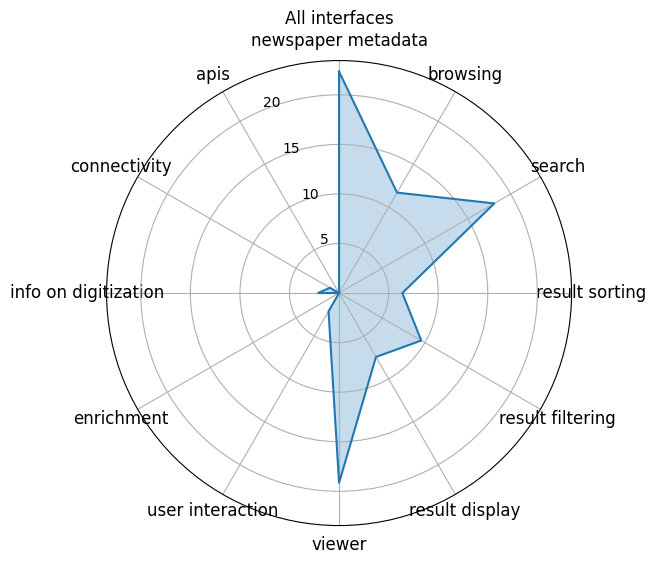

In [35]:
# take only the last column: Total per feature family, in percent
values = level_0_copy.iloc[:,4:].T.values
build_single_radar_free(labels, values, "All interfaces",figure_title='all-interfaces-global', output_type='png')

#### Metadata (global)

In [36]:
metadata = base.loc['newspaper metadata'].copy()
metadata.loc[:,'Total'] = metadata.sum(axis=1)
#metadata['Total (%)'] = metadata['Total']/metadata['Total'].sum() * 100
metadata['Total (%)'] = metadata['Total']/24 * 100
metadata.loc[:,'Total']

Property
Alternative titles              6.127660
Place of publication            9.191489
Geographic coverage             3.063830
Publisher                       6.127660
Date range                      9.191489
Periodicity                     3.063830
ISSN, OCLC, LCCN                0.000000
External links                  6.127660
Historical description          3.063830
Language                        3.063830
Calendar view of issues         6.127660
Indication of archive holder    9.191489
Name: Total, dtype: float64

In [37]:
metadata.shape[0]

12

In [38]:
metadata['Total']

Property
Alternative titles              6.127660
Place of publication            9.191489
Geographic coverage             3.063830
Publisher                       6.127660
Date range                      9.191489
Periodicity                     3.063830
ISSN, OCLC, LCCN                0.000000
External links                  6.127660
Historical description          3.063830
Language                        3.063830
Calendar view of issues         6.127660
Indication of archive holder    9.191489
Name: Total, dtype: float64

In [39]:
metadata.sort_values('Total (%)').loc[:, 'Total (%)']

Property
ISSN, OCLC, LCCN                 0.000000
Geographic coverage             12.765957
Periodicity                     12.765957
Historical description          12.765957
Language                        12.765957
Alternative titles              25.531915
Publisher                       25.531915
External links                  25.531915
Calendar view of issues         25.531915
Place of publication            38.297872
Date range                      38.297872
Indication of archive holder    38.297872
Name: Total (%), dtype: float64

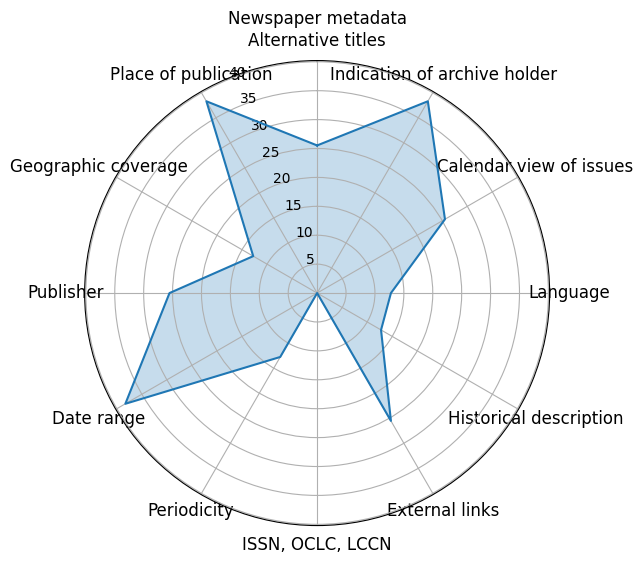

In [40]:
values_metadata = metadata.iloc[:,4:].T.values
build_single_radar_free(metadata.index, values_metadata, title="Newspaper metadata", figure_title="metadata-global", output_type='png')

#### Browsing

In [41]:
browsing = base.loc['browsing'].copy()
browsing.loc[:,'Total'] = browsing.sum(axis=1)
browsing['Total (%)'] = browsing['Total']/24 * 100
browsing.loc[:,'Total']

Property
By date                             9.191489
By title                            9.191489
By place of publication             9.191489
By user tag                         0.000000
By newspaper thematic (metadata)    6.127660
Name: Total, dtype: float64

In [42]:
browsing.shape[0]

5

In [43]:
browsing.sort_values('Total (%)').loc[:, 'Total (%)']

Property
By user tag                          0.000000
By newspaper thematic (metadata)    25.531915
By date                             38.297872
By title                            38.297872
By place of publication             38.297872
Name: Total (%), dtype: float64

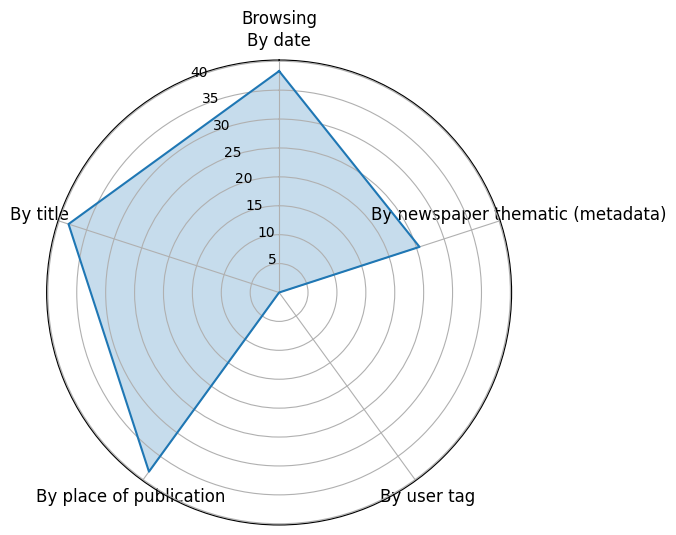

In [44]:
values_browsing = browsing.iloc[:,4:].T.values
build_single_radar_free(browsing.index, values_browsing, title="Browsing", figure_title="browsing-global", output_type='png')

#### Search

In [45]:
search = base.loc['search'].copy()
search.loc[:,'Total'] = search.sum(axis=1)
search['Total (%)'] = search['Total']/24 * 100
search['Total']

Property
Keyword search                          6.12766
Query autocomplete                      3.06383
Boolean operators                       3.06383
Phrase search                           6.12766
Fuzzy search                            0.00000
Wild card                               6.12766
Proximity search                        0.00000
Limit by date range                     6.12766
Limit by language                       3.06383
Limit by NP title(s)                    6.12766
Limit by place of publication           6.12766
Limit by NP thematic (from metadata)    3.06383
Limit by NP segments                    0.00000
Limit by article category               0.00000
Limit by article length                 0.00000
Limit by archival holder                0.00000
Limit by license                        3.06383
Query suggestion                        0.00000
Search by NE                            0.00000
Name: Total, dtype: float64

In [46]:
search.shape[0]

19

In [47]:
search.sort_values('Total (%)').loc[:, 'Total (%)']

Property
Search by NE                             0.000000
Fuzzy search                             0.000000
Limit by archival holder                 0.000000
Proximity search                         0.000000
Limit by article length                  0.000000
Query suggestion                         0.000000
Limit by article category                0.000000
Limit by NP segments                     0.000000
Query autocomplete                      12.765957
Boolean operators                       12.765957
Limit by license                        12.765957
Limit by language                       12.765957
Limit by NP thematic (from metadata)    12.765957
Keyword search                          25.531915
Limit by date range                     25.531915
Wild card                               25.531915
Phrase search                           25.531915
Limit by place of publication           25.531915
Limit by NP title(s)                    25.531915
Name: Total (%), dtype: float64

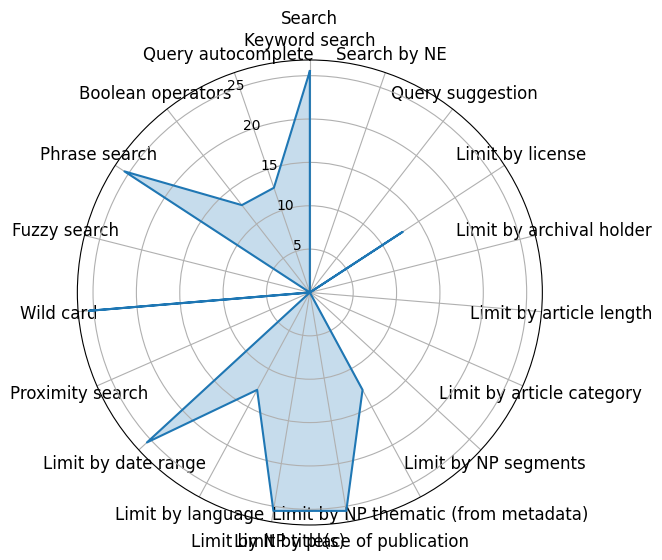

In [48]:
values_search = search.iloc[:,4:].T.values
build_single_radar_free(search.index, values_search, title="Search", figure_title="search-global", output_type='png')

#### Result display

In [49]:
rd = base.loc['result display'].copy()
rd.loc[:,'Total'] = rd.sum(axis=1)
rd['Total (%)'] = rd['Total']/24 * 100
rd['Total']

Property
Distribution over time                     6.127660
Distribution by publication place          0.000000
Distribution by NP                         9.191489
Distribution by place names in articles    0.000000
Snippet preview                            3.063830
Search highlight in facsimiles             3.063830
Search highlight in text                   0.000000
Ngrams                                     0.000000
Name: Total, dtype: float64

In [50]:
rd.shape[0]

8

In [51]:
rd.sort_values('Total (%)').loc[:, 'Total (%)']

Property
Distribution by publication place           0.000000
Distribution by place names in articles     0.000000
Search highlight in text                    0.000000
Ngrams                                      0.000000
Snippet preview                            12.765957
Search highlight in facsimiles             12.765957
Distribution over time                     25.531915
Distribution by NP                         38.297872
Name: Total (%), dtype: float64

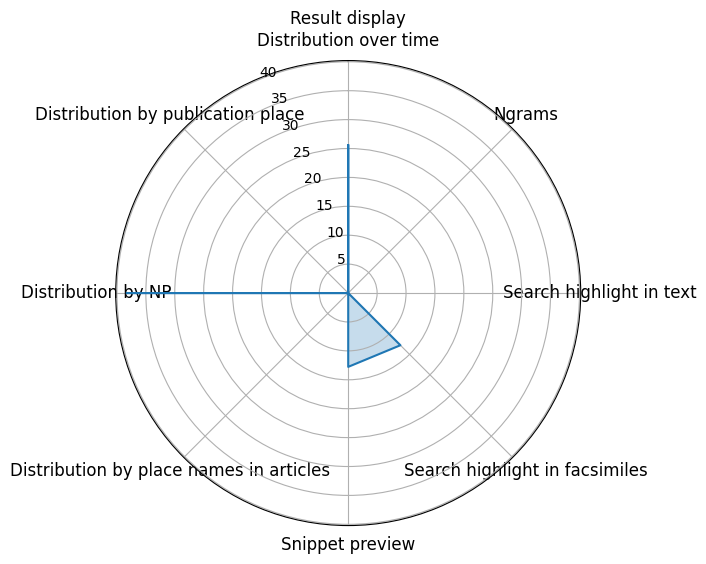

In [52]:
values_rd = rd.iloc[:,4:].T.values
build_single_radar_free(rd.index, values_rd, title="Result display", figure_title="result-display-global", output_type='png')

#### Result filtering

In [53]:
rf = base.loc['result filtering'].copy()
rf.loc[:,'Total'] = rf.sum(axis=1)
rf['Total (%)'] = rf['Total']/24 * 100
rf['Total']

Property
By NP titles                        3.06383
By periodicity                      0.00000
By NP orientation                   0.00000
By newspaper thematic (metadata)    3.06383
By content types                    3.06383
By sections                         0.00000
By events                           0.00000
By persons                          0.00000
By organisations                    0.00000
By places mentioned in text         0.00000
By time period                      6.12766
By topics                           0.00000
By manual tags                      0.00000
By publication place                6.12766
By archive                          0.00000
By publisher                        0.00000
By article length                   0.00000
By authors                          0.00000
By segmentation level               0.00000
By language                         3.06383
By license                          3.06383
By online pub. date                 0.00000
Name: Total, dtype: flo

In [54]:
rf.shape[0]

22

In [55]:
rf.sort_values('Total (%)').loc[:, 'Total (%)']

Property
By online pub. date                  0.000000
By periodicity                       0.000000
By NP orientation                    0.000000
By segmentation level                0.000000
By sections                          0.000000
By events                            0.000000
By persons                           0.000000
By organisations                     0.000000
By places mentioned in text          0.000000
By authors                           0.000000
By topics                            0.000000
By manual tags                       0.000000
By article length                    0.000000
By archive                           0.000000
By publisher                         0.000000
By language                         12.765957
By NP titles                        12.765957
By license                          12.765957
By content types                    12.765957
By newspaper thematic (metadata)    12.765957
By publication place                25.531915
By time period           

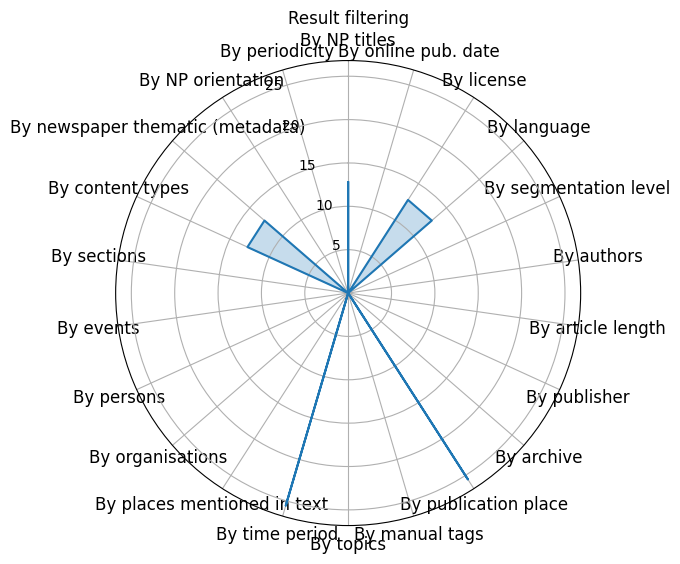

In [56]:
values_rf = rf.iloc[:,4:].T.values
build_single_radar_free(rf.index, values_rf, title="Result filtering", figure_title="result-filtering-global", output_type='png')

#### Result sorting

In [57]:
rs = base.loc['result sorting'].copy()
rs.loc[:,'Total'] = rs.sum(axis=1)
rs['Total (%)'] = rs['Total']/24 * 100
rs['Total']

Property
By relevance           3.06383
By date                6.12766
By NP title            6.12766
By article title       0.00000
By content type        0.00000
By online pub. date    3.06383
By author              0.00000
By quality of text     0.00000
By language            0.00000
By popularity          0.00000
Name: Total, dtype: float64

In [58]:
rs.shape[0]

10

In [59]:
rs.sort_values('Total (%)').loc[:, 'Total (%)']

Property
By article title        0.000000
By content type         0.000000
By author               0.000000
By quality of text      0.000000
By language             0.000000
By popularity           0.000000
By relevance           12.765957
By online pub. date    12.765957
By date                25.531915
By NP title            25.531915
Name: Total (%), dtype: float64

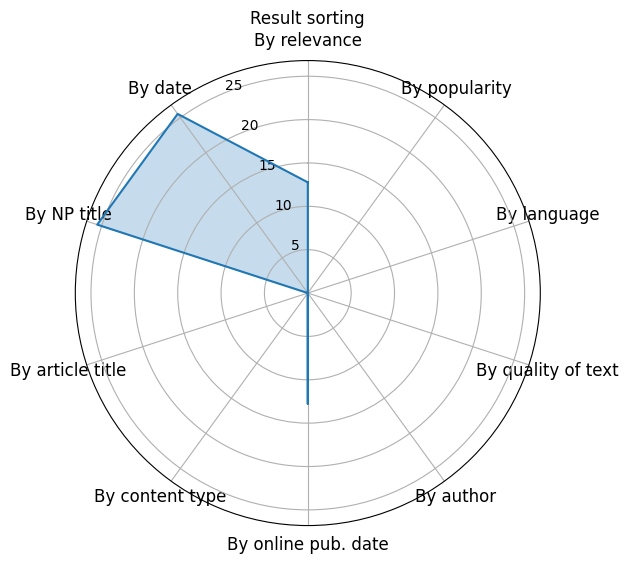

In [60]:
values_rs = rs.iloc[:,4:].T.values
build_single_radar_free(rs.index, values_rs, title="Result sorting", figure_title="result-sorting-global", output_type='png')

#### Viewer

In [61]:
viewer = base.loc['viewer'].copy()
viewer.loc[:,'Total'] = viewer.sum(axis=1)
viewer['Total (%)'] = viewer['Total']/24 * 100
viewer.loc[:,'Total']

Property
Facsimile displayed                  9.191489
OCRed text display                   3.063830
Show full page                       9.191489
Interactive mini-map                 3.063830
Overview of avail. issues            9.191489
Search in viewed page                6.127660
Option to continue to next page      9.191489
Option to continue to next result    6.127660
Name: Total, dtype: float64

In [62]:
viewer.shape[0]

8

In [63]:
viewer.sort_values('Total (%)').loc[:, 'Total (%)']

Property
OCRed text display                   12.765957
Interactive mini-map                 12.765957
Search in viewed page                25.531915
Option to continue to next result    25.531915
Facsimile displayed                  38.297872
Show full page                       38.297872
Overview of avail. issues            38.297872
Option to continue to next page      38.297872
Name: Total (%), dtype: float64

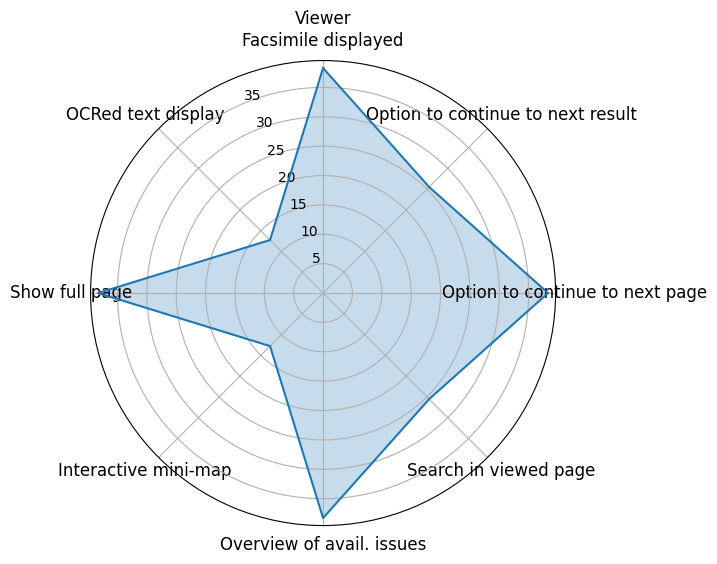

In [64]:
values_viewer = viewer.iloc[:,4:].T.values
build_single_radar_free(viewer.index, values_viewer, title="Viewer", figure_title="viewer-global", output_type='png')

#### Info on digitization

In [65]:
info = base.loc['info on digitization'].copy()
info.loc[:,'Total'] = info.sum(axis=1)
info['Total (%)'] = info['Total']/24 * 100
info.loc[:,'Total']

Property
OLR at article level                0.00000
OCR confidence scores               0.00000
OLR confidence scores               0.00000
Documentation of biases             0.00000
Search result relevance score       0.00000
Digitisation date at title level    0.00000
Scan resolution                     0.00000
Used OCR tools                      0.00000
Copyright notice                    6.12766
Documentation of scan methods       0.00000
Name: Total, dtype: float64

In [66]:
info.shape[0]

10

In [67]:
info.sort_values('Total (%)').loc[:, 'Total (%)']

Property
OLR at article level                 0.000000
OCR confidence scores                0.000000
OLR confidence scores                0.000000
Documentation of biases              0.000000
Search result relevance score        0.000000
Digitisation date at title level     0.000000
Scan resolution                      0.000000
Used OCR tools                       0.000000
Documentation of scan methods        0.000000
Copyright notice                    25.531915
Name: Total (%), dtype: float64

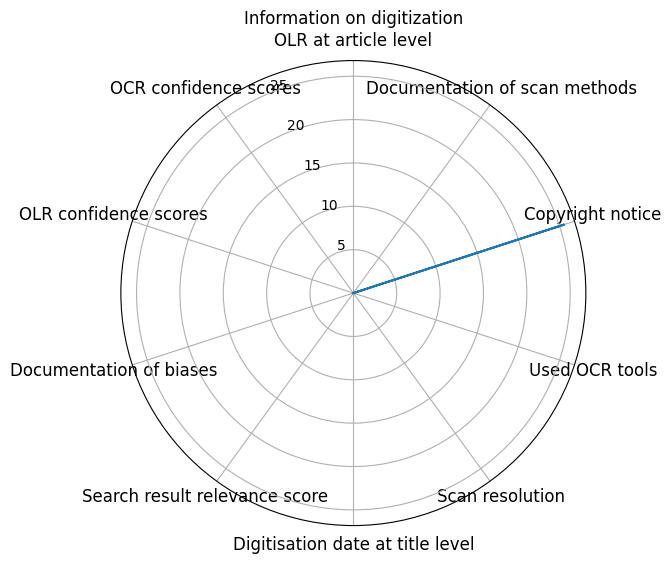

In [68]:
values_info = info.iloc[:,4:].T.values
build_single_radar_free(info.index, values_info, title="Information on digitization", figure_title="info-global", output_type='png')

#### User interaction 

In [69]:
user = base.loc['user interaction'].copy()
user.loc[:,'Total'] = user.sum(axis=1)
user['Total (%)'] = user['Total']/24 * 100
user['Total']

Property
Save articles to favorites          0.00000
Save queries to favorites           0.00000
Tag articles                        0.00000
Keep track of viewed materials      0.00000
Article recommendations             0.00000
Permalinks                          6.12766
Export citation                     0.00000
Option to correct OCR               0.00000
Option to correct OLR               0.00000
Add/edit of metadata                0.00000
Screenshot tool                     0.00000
Bulk downloads                      0.00000
Organise articles in collections    0.00000
Contrastive view of collections     0.00000
Name: Total, dtype: float64

In [70]:
user.shape[0]

14

In [71]:
user.sort_values('Total (%)').loc[:, 'Total (%)']

Property
Save articles to favorites           0.000000
Save queries to favorites            0.000000
Tag articles                         0.000000
Keep track of viewed materials       0.000000
Article recommendations              0.000000
Export citation                      0.000000
Option to correct OCR                0.000000
Option to correct OLR                0.000000
Add/edit of metadata                 0.000000
Screenshot tool                      0.000000
Bulk downloads                       0.000000
Organise articles in collections     0.000000
Contrastive view of collections      0.000000
Permalinks                          25.531915
Name: Total (%), dtype: float64

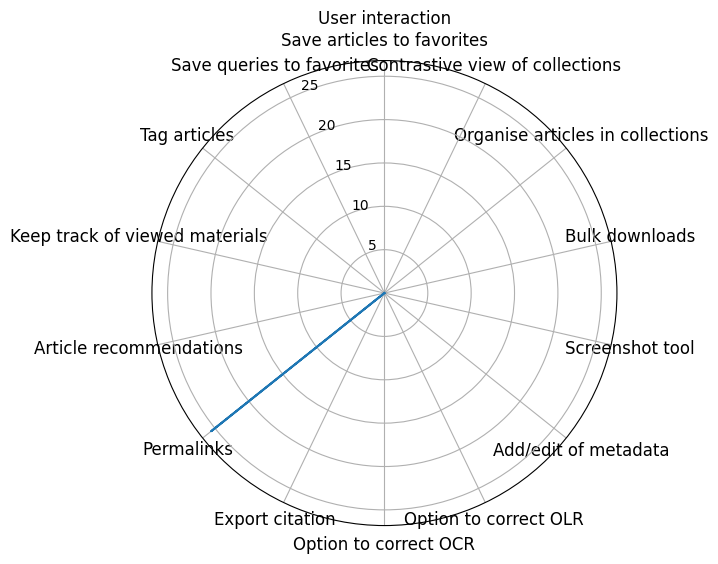

In [72]:
values_user = user.iloc[:,4:].T.values
build_single_radar_free(user.index, values_user, title="User interaction", figure_title="user-global", output_type='png')

#### Enrichment

In [73]:
enrich = base.loc['enrichment'].copy()
enrich = enrich.drop('Query')
enrich.loc[:,'Total'] = enrich.sum(axis=1)
enrich['Total (%)'] = enrich['Total']/24 * 100
enrich['Total']

/tmp/ipykernel_52652/2409441392.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  enrich.loc[:,'Total'] = enrich.sum(axis=1)


Property
NERC                                 0.0
Entity linking                       0.0
Automatic post-OCR correction        0.0
Crowd-sourced post-OCR correction    0.0
Topic Modeling                       0.0
Text re-use                          0.0
Sentiment Analysis                   0.0
Recommendations                      0.0
Event detection                      0.0
Name: Total, dtype: float64

In [74]:
enrich.sort_values('Total (%)').loc[:, 'Total (%)']

Property
NERC                                 0.0
Entity linking                       0.0
Automatic post-OCR correction        0.0
Crowd-sourced post-OCR correction    0.0
Topic Modeling                       0.0
Text re-use                          0.0
Sentiment Analysis                   0.0
Recommendations                      0.0
Event detection                      0.0
Name: Total (%), dtype: float64

In [75]:
enrich.iloc[:,4:]

,Total (%)
Property,
NERC,0.0
Entity linking,0.0
Automatic post-OCR correction,0.0
Crowd-sourced post-OCR correction,0.0
Topic Modeling,0.0
Text re-use,0.0
Sentiment Analysis,0.0
Recommendations,0.0
Event detection,0.0


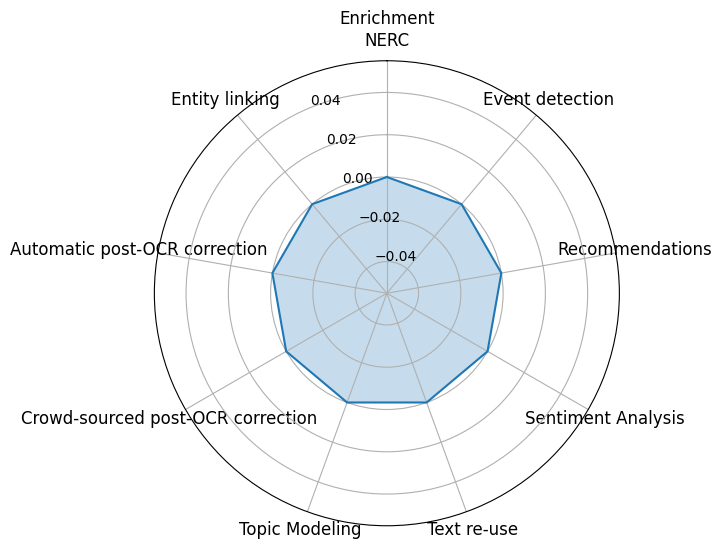

In [76]:
values_enrich = enrich.iloc[:,4:].T.values
build_single_radar_free(enrich.index, values_enrich, title="Enrichment", figure_title="enrichment-global", output_type='png')

#### Connectivity

In [77]:
conn = base.loc['connectivity'].copy()
conn.loc[:,'Total'] = conn.sum(axis=1)
conn['Total (%)'] = conn['Total']/24 * 100
conn['Total']

Property
Third party identifiers        3.06383
Links to other repositories    0.00000
SW technologies                0.00000
Name: Total, dtype: float64

In [78]:
conn.shape[0]

3

In [79]:
conn.sort_values('Total (%)').loc[:, 'Total (%)']

Property
Links to other repositories     0.000000
SW technologies                 0.000000
Third party identifiers        12.765957
Name: Total (%), dtype: float64

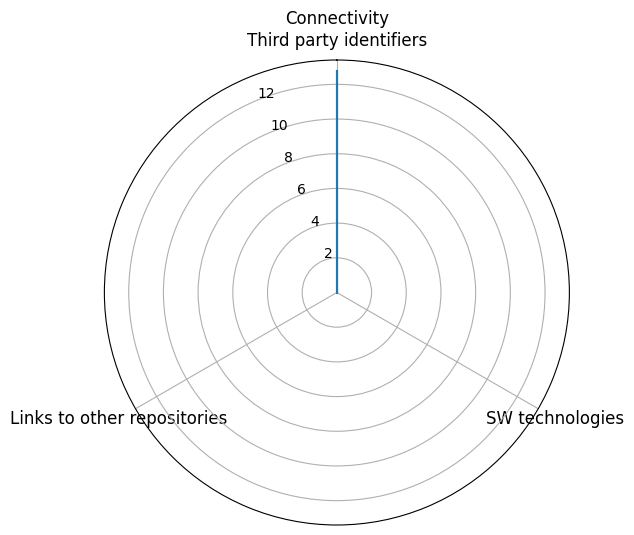

In [80]:
values_conn = conn.iloc[:,4:].T.values
build_single_radar_free(conn.index, values_conn, title="Connectivity", figure_title="connectivity-global", output_type='png')

#### APIs

In [81]:
apis = base.loc['apis'].copy()
apis.loc[:,'Total'] = apis.sum(axis=1)
apis['Total (%)'] = apis['Total']/24 * 100
apis['Total']

/tmp/ipykernel_52652/1500865402.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  apis.loc[:,'Total'] = apis.sum(axis=1)


Property
Link to source code of the interface    0.0
API                                     0.0
IIIF Image API                          0.0
IIIF Presentation API                   0.0
Name: Total, dtype: float64

In [82]:
apis.shape[0]

4

In [83]:
apis.sort_values('Total (%)').loc[:, 'Total (%)']

Property
Link to source code of the interface    0.0
API                                     0.0
IIIF Image API                          0.0
IIIF Presentation API                   0.0
Name: Total (%), dtype: float64

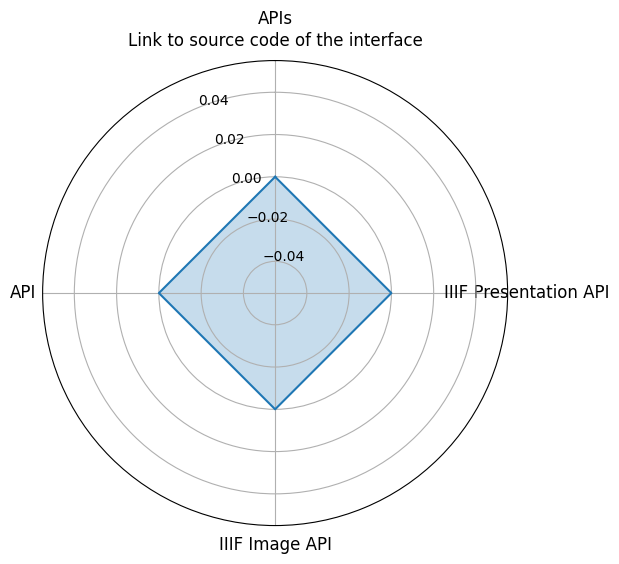

In [84]:
values_apis = apis.iloc[:,4:].T.values
build_single_radar_free(apis.index, values_apis, title="APIs", figure_title="apis-global", output_type='png')

#### Mapping

:warning: Ainda falta criar esse tsv para as hemerotecas em protuguês.

In [86]:
base_mapping = pd.read_csv("../../../data/avaliacao_interfaces/InterfaceReview-pt-2023-mapping.tsv", sep="\t", index_col= [0,1,2], skipinitialspace=True)

In [87]:
base_mapping.head()

Hemeroteca Digital Brasileira (HDB)  \
High level Criteria Property family Property                                                                          
Interfaces          interface       URL                                                   http://memoria.bn.br/hdb/   
                                    Target area                                                                  BR   
                                    Creator                                            Fundação Biblioteca Nacional   
                                    Purpose and scope             Coleção de periódicos digitalizados do acervo ...   
                                    Approximate date of creation                                               2012   

                                                                   Biblioteca Nacional Digital de Portugal (BND-PT)  \
High level Criteria Property family Property                                                                          
Interfaces          interface       URL                                        https://bndigital.bnportugal.gov.pt/   
                                    Target area                                                                  PT   
                                    Creator                                         Biblioteca Nacional de Portugal   
                                    Purpose and scope             Acervo digitalizado da Biblioteca Nacional de ...   
                                    Approximate date of creation                                                  u   

                                                                                 Hemeroteca Digital de Lisboa (HDL)  
High level Criteria Property family Property                                                                         
Interfaces          interface       URL                                     https://hemerotecadigital.cm-lisboa.pt/  
                                    Target area                                                                  PT  
                                    Creator                                                   Bibliotecas de Lisboa  
                                    Purpose and scope             Periódicos, legislação obras raras digitalizad...  
                                    Approximate date of creation                                                  u

In [88]:
# trim
base_mapping = trim_all_columns(base_mapping)

base_mapping = base_mapping.drop('Interfaces', level=0)
base_mapping = base_mapping.drop('Other', level=2)
base_mapping = base_mapping.drop('Download options (file formats)', level=2)
base_mapping = base_mapping.drop('Newspaper date range', level=2)
base_mapping = base_mapping.drop('Number of newspaper titles', level=2)

#Replace n and y by 0 and 1 (ideally to clean in spreadsheet)
base_mapping = base_mapping.replace(to_replace=['y', 'y?', 'y (annotations)', 'y (requires user account - free)', 'n', '?', 'u', 'n?', 'n (?)', 'n (but can signal mistakes)'], 
                   value=[1,1,1,1,0,0,0,0,0,0])

In [89]:
mapping = base_mapping.groupby(level=0).sum(numeric_only=True)

In [90]:
mapping.loc[:,'Total'] = mapping.sum(axis=1)
mapping['Total (%)'] = mapping['Total']/mapping['Total'].sum() * 100

In [91]:
values = mapping.iloc[:,4]
values

High level Criteria
Connectivity                            3.092784
Content filtering                      15.463918
Content search                         32.989691
Generosity                              9.278351
Source criticism                       37.113402
User content management/exploration     2.061856
Name: Total (%), dtype: float64

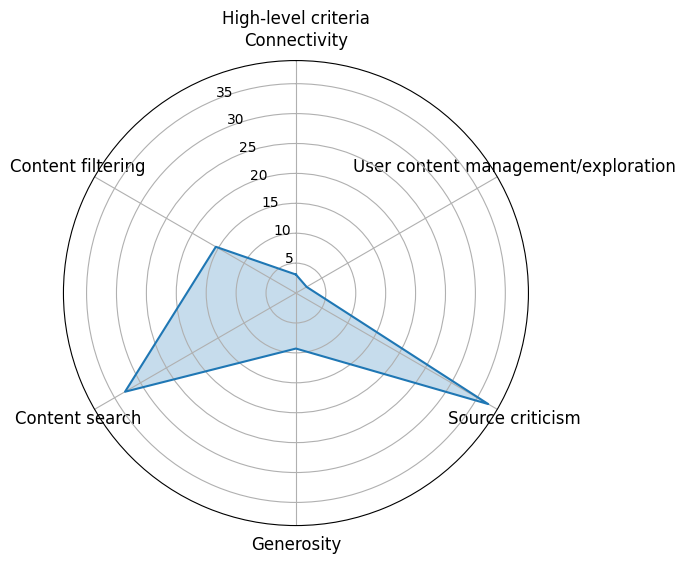

In [92]:
values = mapping.iloc[:,4:].T.values
build_single_radar_free(mapping.index, values, "High-level criteria",figure_title='high-level-criteria',output_type='png')